# **Time Series Revenue Forecasting**


This python notebook contains all the code I used to forecast revenue in my company. <br> I experimented various models to try to fit it to my series.

# **TSA Project overview:**

Following are the steps I took for analysing the time series data:


1.   Data Loading and Cleaning
2.   Univariate Analysis
1.   Arima , Sarima modeling
2.   Prophet to forecast revenue
1.   Prophet 'Additive model' incl. sundays as extra regressor
1.   Prophet 'Multiplicative model' incl. sundays as extra regressor
1.   Final forecasting on July month's revenue data of my company
2.   Conclusion and last words








# Data

Due to obvious reasons I am not authorized to share the organization's revenue data and therapy data publicly, but have the permission to showcase the project, since it was just an experimentation work and part of a whole project.

The **amount payables are randomly generated** (just for the output of this file when shared on github, rest the plots and analysis was done on real data)

In many places i have **hidden the actual data** by **COMMENTING OUT THE CELLS**

### **Import Libraries**


In [1]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### **Data Loading**

In [2]:
# load the data
df = pd.read_excel('TSA_Project.xlsx')

In [3]:
# display first few rows of the data
df.head()

,LOCATION,DATE,SERVICE NAME,AMOUNT PAYABLE
0,"Continua Kids, Rohtak",2023-07-01 00:00:10,ABA 1 HOUR,13000
1,"Continua Kids, Rohtak",2023-07-01 00:00:10,ABA 1.5 HOURS,18700
2,"Continua Kids, Rohtak",2023-07-01 00:00:10,Applied Behavior Analysis,0
3,"Continua Kids, Rohtak",2023-07-01 00:00:10,Applied Behavior Analysis,0
4,"Continua Kids, Rohtak",2023-07-01 00:00:10,Applied Behavior Analysis,0


### **Data Exploration and Data Cleaning**

In [4]:
# display last few rows
df.tail()

,LOCATION,DATE,SERVICE NAME,AMOUNT PAYABLE
417478,"Continua Kids, Rohtak",2025-07-01 00:00:10,Applied Behavior Analysis,0
417479,"Continua Kids, Sector 6, Karnal (Carritos)",2025-07-01 00:00:10,Occupational Therapy,0
417480,"Continua Kids, Jalandhar",2025-07-01 00:00:10,NaN,2000
417481,"Continua Kids, Jalandhar",2025-07-01 00:00:10,NaN,2000
417482,"Continua Kids, Bhiwadi",2025-07-01 00:00:10,Speech Therapy,800


The data has multiple series like Location, Service name (therapies), so we can later on try using **Multi-Series Forecasting.**

In [5]:
# display the metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417483 entries, 0 to 417482
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   LOCATION        417483 non-null  object        
 1   DATE            417483 non-null  datetime64[ns]
 2   SERVICE NAME    416525 non-null  object        
 3   AMOUNT PAYABLE  417479 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 12.7+ MB


There are over **4 Lakh rows** of data to use for forecasting. Null/Blanks are present in SERVICE NAME and AMOUNT PAYABLE.

As per the domain knowledge about the data, I was told to safely **remove rows whose SERVICE NAME is blank**, so we'll remove the empty rows.

In [6]:
# remove missing rows for null values in SERVICE NAME

print(f"Before: {df.shape}")
df = df[df['SERVICE NAME'].notna() & (df['SERVICE NAME'].str.strip() != '')]
print(f"After: {df.shape}")

Before: (417483, 4)
After: (416525, 4)


In [7]:
# check the metadata again
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416525 entries, 0 to 417482
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   LOCATION        416525 non-null  object        
 1   DATE            416525 non-null  datetime64[ns]
 2   SERVICE NAME    416525 non-null  object        
 3   AMOUNT PAYABLE  416525 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 15.9+ MB


Okay, we have removed all the blanks from our data.

In [8]:
# how much data do I have : Start date , End date

print(f"Start date: {df['DATE'].min()}")
print(f"End date: {df['DATE'].max()}")

Start date: 2023-07-01 00:00:10
End date: 2025-07-20 00:00:10


The dataset spans a little over **2 years**, from July 2023 to July 2025.<br>
This provides enough historical context to analyze and **model both trends and seasonality**.<br>
Given the granularity, the data supports **daily, weekly, and monthly** forecasting, making it suitable for **short-term and medium-term revenue predictions.**

In [9]:
# How many locations does our company operate in?
df['LOCATION'].nunique()

31

In [114]:
# list all the clinic locations
# for i,j in enumerate(df['LOCATION'].unique(), start=1):
#   print(f' {i}. {j}')

There are a total of 31 Branches of my company. So, we can **forecast the monthly or weekly revenue for each individual clinic** later.


In [11]:
# explore all the services provided by the company
df['SERVICE NAME'].nunique()

223

In [12]:
# list all the services provided
df['SERVICE NAME'].unique()

array(['ABA 1 HOUR', 'ABA 1.5 HOURS', 'Applied Behavior Analysis',
       'Consultation', 'Developmental Assessment', 'Follow-up Consult',
       'Occupational Therapy',
       'OT/PT/SPECIAL ED. 45 MIN FIVE TIMES A WEEK',
       'OT/PT/Special Ed. 45 min Three Times a Week', 'Other Invoice',
       'Physiotherapy', 'Psychological Assessment',
       'Rohtak - OT/PT/SPEECH/SPECIAL ED. 45 MIN FIVE TIMES A WEEK',
       'Rohtak - OT/PT/SPEECH/SPECIAL ED. 45 MIN SIX TIMES A WEEK',
       'Rohtak - OT/PT/Speech/Special Ed. 45 min Three Times a Week',
       'Special Education', 'Speech Therapy',
       'SPEECH THERAPY 45 MIN THREE TIMES A WEEK',
       'ABA 1 HOUR FIVE TIMES A WEEK', 'ABA 2 HOUR FIVE TIMES A WEEK',
       'FARIDABAD - OT/PT/SPEECH/SPECIAL ED. 45 MIN THREE TIMES A WEEK',
       'OT/PT/SPECIAL ED. 45 MIN SIX TIMES A WEEK',
       'ABA Parents Training', 'Full Assessment',
       'NOIDA - OT/PT/SPEECH/SPECIAL ED. 45 MIN, 6 TIMES A WEEK',
       'SPEECH THERAPY 45 MIN FIVE TIM

We can see that there are 223 unique therapies provided, but thats not the case, it's just that the therapies are packaged differently based on the clinic location. <br> **There are mainly 7 therapy services provided**:




1.   OT  : Occupational Therapy
2.   ABA : Applied Behavioural Analysis
3.   ST  : Speech Therapy
4.   SE  : Special Education
5.   PT  : Physio Therapy
6.   COM : Combo pack with all therapies OT/PT/ST/SE/ABA
7.   C   : Assessments, Consultations and Follow-ups
8.   Other : this is not any therapy but the sales of any kit, aid, medicines etc.

So, we need to **categorize all the unique 223 services in these 7 buckets**.



In [13]:
# function to may 223 services to only above categories (function created using GPT)

import re

def map_service_category(service_name):
    name = str(service_name).lower()

    # Category: Consultations, assessments, follow-ups
    if any(x in name for x in ['consult','consultation', 'counselling','assessment', 'assesment', 'follow','follow-up' 'psychologist', 'neurologist', 'test']):
        return 'C'

    # Category: Combo (contains multiple therapies)
    elif '/' in name:
      return 'COM'

    # Category: ABA
    elif 'aba' in name or 'applied behavior analysis' in name or 'school readiness' in name:
        return 'ABA'

    # Category: Occupational Therapy
    elif 'occupational therapy' in name or re.search(r'\bot\b', name) or 'adl' in name:
        return 'OT'

    # Category: Physiotherapy
    elif 'physio' in name or 'physiotherapy' in name or 'ndt' in name:
        return 'PT'

    # Category: Speech Therapy
    elif 'speech' in name or 'oral placement' in name or 'opt' in name:
        return 'ST'

    # Category: Special Education
    elif 'special ed' in name or 'sp. edu' in name or 'spl ed' in name:
        return 'SE'

    # Default fallback
    return 'Other'


In [14]:
# now make a new column ,applying the defined function to SERVICE NAME

df['SERVICE_CATEGORY'] = df['SERVICE NAME'].apply(map_service_category)

In [15]:
# check the value counts of all the therapies

df['SERVICE_CATEGORY'].value_counts()

,count
SERVICE_CATEGORY,
OT,188110
ABA,98314
ST,74535
SE,21293
COM,10846
C,9969
PT,9140
Other,4318


In [115]:
# now i want to check if the mapping was done correctly or not, by randomly inspecting few rows from the data
# df.sample(10)

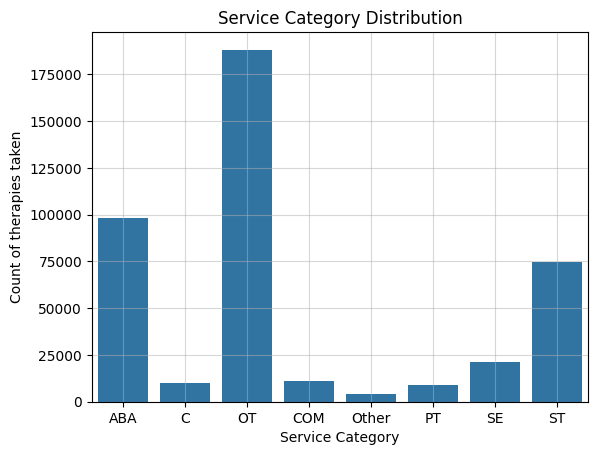

In [17]:
# make a plot for visual understand , which service in the most availed one
sns.countplot(data=df,x='SERVICE_CATEGORY')
plt.xlabel('Service Category')
plt.ylabel('Count of therapies taken')
plt.title('Service Category Distribution')
plt.grid(alpha=0.5)


In the past two years, OT was the most availed service, followed by ABA and Speech therapy. So, OT has a greater contribution in the company's revenue.

In [18]:
# now drop the service name column
df.drop(columns='SERVICE NAME', inplace=True)

In [19]:
df.head()

,LOCATION,DATE,AMOUNT PAYABLE,SERVICE_CATEGORY
0,"Continua Kids, Rohtak",2023-07-01 00:00:10,13000,ABA
1,"Continua Kids, Rohtak",2023-07-01 00:00:10,18700,ABA
2,"Continua Kids, Rohtak",2023-07-01 00:00:10,0,ABA
3,"Continua Kids, Rohtak",2023-07-01 00:00:10,0,ABA
4,"Continua Kids, Rohtak",2023-07-01 00:00:10,0,ABA


In [20]:
# convert Date column to datetime
import datetime
df.loc[:, 'DATE'] = pd.to_datetime(df['DATE'])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416525 entries, 0 to 417482
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LOCATION          416525 non-null  object        
 1   DATE              416525 non-null  datetime64[ns]
 2   AMOUNT PAYABLE    416525 non-null  object        
 3   SERVICE_CATEGORY  416525 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 15.9+ MB


**We are done with basic data understanding and data preprocessing. Now let's move to**:


1.   univariate time series analysis, checking for stationarity, dealing with non-stationarity, exploring models like ARIMA, SARIMAX, smoothing, holts, holts winter
2.   after this we can explore ML/DL based models like LGBM/XGBoost/RandomForest, RNN(LSTM), which would require additional features like date extracted features: day, month, year ,dayofweek, weekofyear ,is_weekend, is_month_start, etc
3.  after this we will move to Multi-Series Analysis using Prophet, Forecasting amount separately per service category, per location etc.

### **Time Series Analysis : Univariate for OT revenue forecast**

In [22]:
# filter for only "OT"
df_ot = df[df['SERVICE_CATEGORY']=='OT'].copy()

In [23]:
# check if the table has only OTs
df_ot['SERVICE_CATEGORY'].unique()

array(['OT'], dtype=object)

In [24]:
# remove zeros or invalid amounts
df_ot = df_ot[df_ot['AMOUNT PAYABLE']>0]

In [25]:
# Aggregate , sum of payables per date across all clinics
df_ot_daily = df_ot.groupby('DATE')['AMOUNT PAYABLE'].sum().reset_index()

# sort by date
df_ot_daily.sort_values('DATE', inplace=True)

In [116]:
# df_ot_daily

In [27]:
# get DATE index for TSA

df_ot_daily.set_index('DATE', inplace=True)

In [28]:
# daily freq
df_ot_daily = df_ot_daily.asfreq('D')

In [117]:
# df_ot_daily

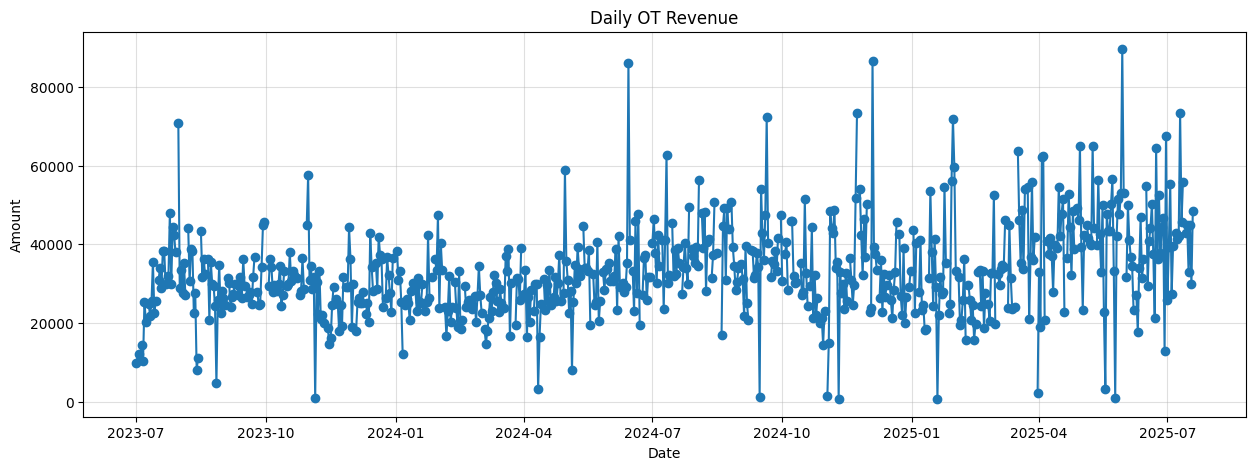

In [30]:
# visualize the time series
plt.figure(figsize=(15,5))
plt.plot(df_ot_daily.index, df_ot_daily['AMOUNT PAYABLE'], marker='o')
plt.title("Daily OT Revenue")
plt.xlabel("Date")
plt.ylabel("Amount")
plt.grid(True , alpha=0.4)
plt.show()

In [31]:
# are there are NaN or null, check for it
df_ot_daily.isna().sum()

,0
AMOUNT PAYABLE,108


data has null values on Sundays, so replace all the NaN with 0s

In [32]:
# impute the missing days with 0
df_ot_daily.fillna(0, inplace=True)

/tmp/ipython-input-614140826.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ot_daily.fillna(0, inplace=True)


In [33]:
df_ot_daily.isna().sum()

,0
AMOUNT PAYABLE,0


All the missing values are now replaced with 0s, we did that so that our models learn to capture that no-billing is done on sundays.

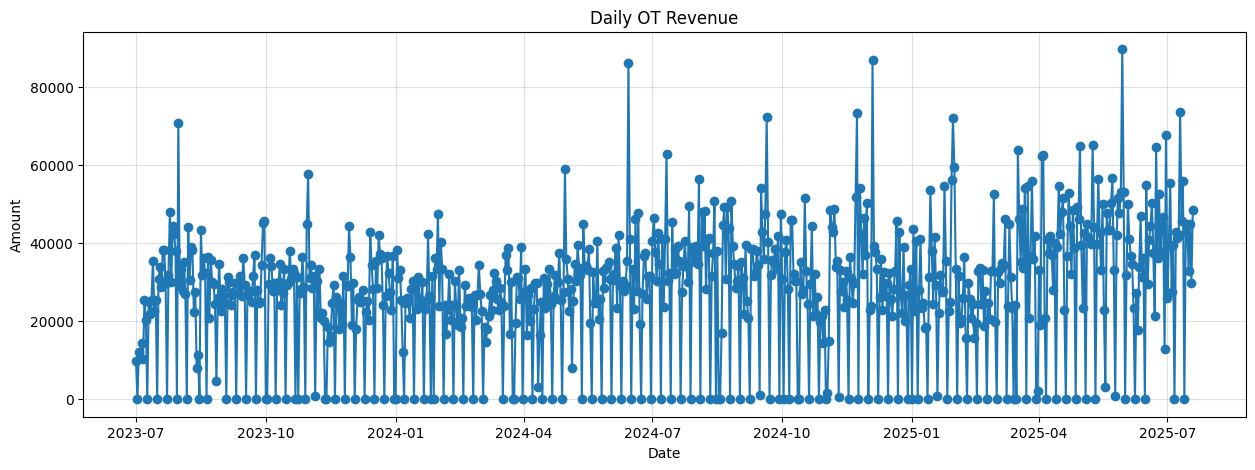

In [34]:
# now again plot the daily revenue sales plot
# visualize the time series
plt.figure(figsize=(15,5))
plt.plot(df_ot_daily.index, df_ot_daily['AMOUNT PAYABLE'], marker='o')
plt.title("Daily OT Revenue")
plt.xlabel("Date")
plt.ylabel("Amount")
plt.grid(True , alpha=0.4)
plt.show()

In [35]:
# Now lets decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose

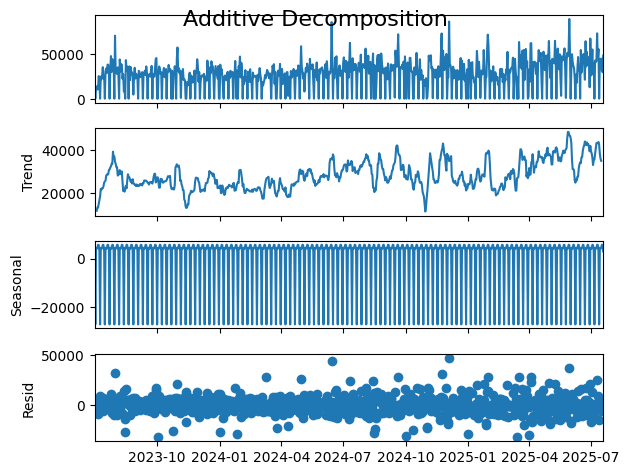

In [36]:
# Choose 'additive' first
result_add = seasonal_decompose(df_ot_daily, model='additive', period=7)  # weekly seasonality
result_add.plot()
plt.suptitle("Additive Decomposition", fontsize=16)
plt.show()

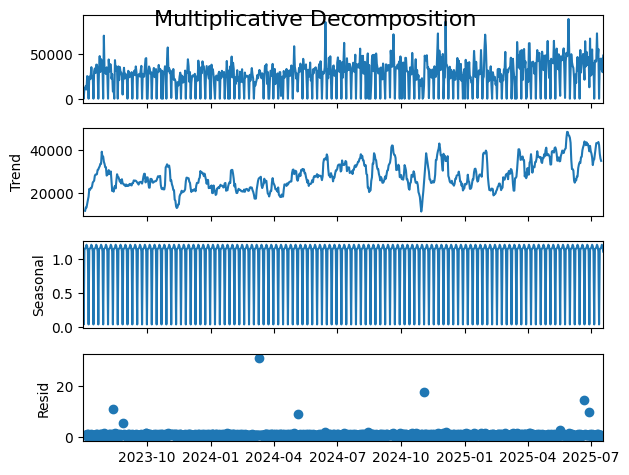

In [37]:
# Choose 'multiplicative' now
result_mul = seasonal_decompose(df_ot_daily +1 , model='multiplicative', period=7)
result_mul.plot()
plt.suptitle("Multiplicative Decomposition", fontsize=16)
plt.show()

It can be observed that both resudues have mean centred at 0, but in Multiplicative decomposition , its more stable and less spread. So, its likely **Multiplicative series** in nature.

In [38]:
# we can double check
result_add = seasonal_decompose(df_ot_daily, model='additive', period=7)
result_mul = seasonal_decompose(df_ot_daily+1, model='multiplicative', period=7)

# Compare residual variance of voth the decomposed series
print("Additive residual variance:", result_add.resid.var())
print("Multiplicative residual variance:", result_mul.resid.var())

Additive residual variance: 84768629.71034804
Multiplicative residual variance: 2.398335993135911


Since **Lower residual variance = better model fit**, so its confirmed that the series inherent nature is **Multiplicative**.

**Why multiplicative?**

Because revenue scales with volume (ex, more the no. of sessions takes ---> higher will be the revenue)

In [39]:
""" alright now lets perform log transformation to make the series additive , (useful for modelling),
but before that we have to make sure we habe no 0 , which we have on sundays and holidays,
so nned to replace 0 with nan and then ffill or bfill, to make it strictly positive. """

' alright now lets perform log transformation to make the series additive , (useful for modelling),\nbut before that we have to make sure we habe no 0 , which we have on sundays and holidays,\nso nned to replace 0 with nan and then ffill or bfill, to make it strictly positive. '

In [40]:
# replace the 0s with nan value
df_ot_daily = df_ot_daily.replace(0, np.nan)

# forward/backward fill the nan values
df_ot_daily = df_ot_daily.fillna(method='ffill')

# do a log transformation
log_df_ot_daily = np.log(df_ot_daily)

/tmp/ipython-input-1784654526.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ot_daily = df_ot_daily.fillna(method='ffill')


In [125]:
# log_df_ot_daily

Now, our series has become additive in nature. Try to decompose and check that.

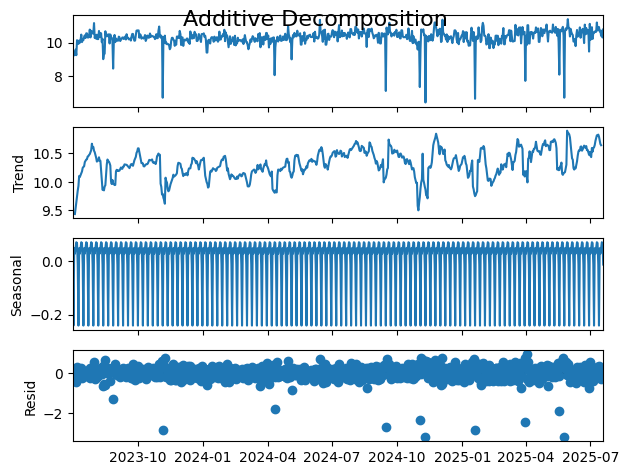

In [42]:
# seasonal decomposition 'additive'
result_add = seasonal_decompose(log_df_ot_daily, model='additive', period=7)  # weekly seasonality
result_add.plot()
plt.suptitle("Additive Decomposition", fontsize=16)
plt.show()

In [43]:
# now let's check for stationarity

# WHY?
# Because most time series models like ARIMA, SARIMA assume stationarity.

Text(0.5, 1.0, 'Stationarity Check: Rolling Mean & Std')

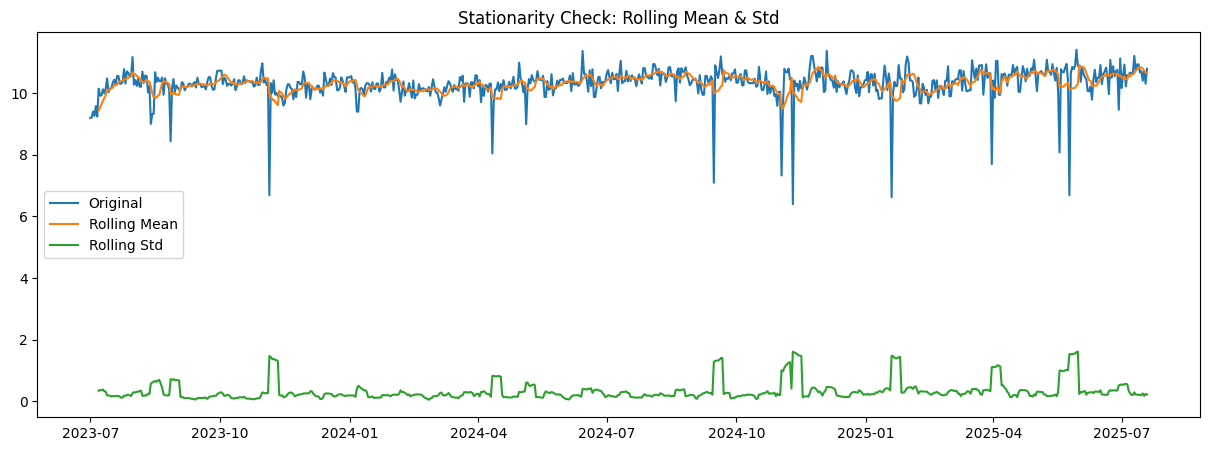

In [44]:
# plot the rolling mean and the std dev
rolling_mean = log_df_ot_daily.rolling(window=7).mean()
rolling_std = log_df_ot_daily.rolling(window=7).std()

# plot the mean and std
plt.figure(figsize=(15,5))
plt.plot(log_df_ot_daily, label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend(loc='best')
plt.title("Stationarity Check: Rolling Mean & Std")



Visually it looks like there is some **stationarity**.

Lets **perform ADF (augumented dickey fuller test)** to see if the series is stationary or not. <br> *(if unit roots are present in the series mathematical equation then its not stationary)*

In [45]:
# perform ADF test
from statsmodels.tsa.stattools import adfuller

test = adfuller(log_df_ot_daily)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])

print("Stationary" if test[1] <= 0.05 else "Non-Stationary")

ADF Statistic: -6.817407
p-value: 0.000000
Stationary


Okay, so our **series is Stationary**. This means that the series is eligible for models like ARIMA, SARIMA.

In [46]:
# now plot ACF and PACF plots to determine AR , MA orders for ARIMA, SARIMA

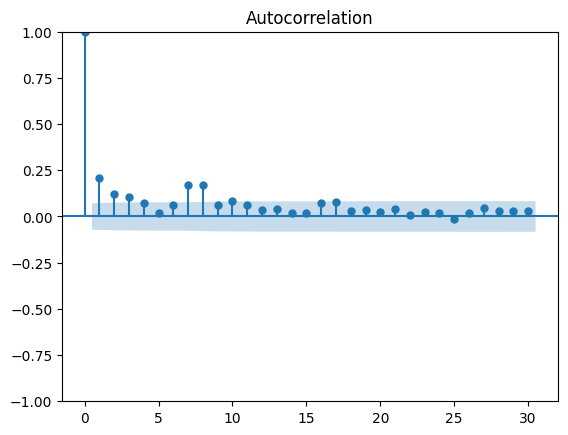

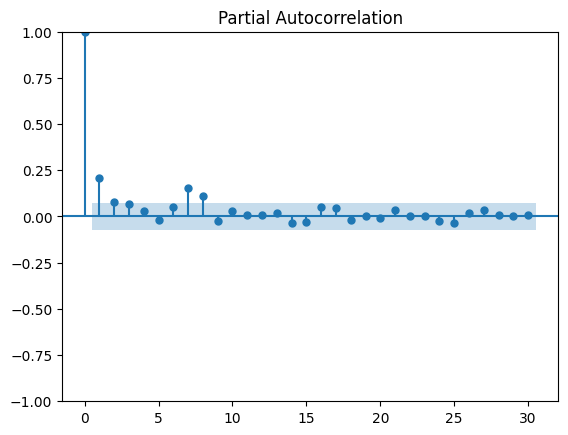

In [47]:
# acf and pacf plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(log_df_ot_daily, lags=30)
plot_pacf(log_df_ot_daily, lags=30)
plt.show()

Since both of them have, some significant lags and no decay, so **its an ARMA process**, or ARIMA with I=0 (as out series is already stationary)



#### **Modelling ARIMA process**

In [124]:
# check the data at hand
# log_df_ot_daily

In [49]:
# okay now perform Train-Test split
train_size = int(len(log_df_ot_daily) * 0.9)
train_data, test_data = log_df_ot_daily[:train_size], log_df_ot_daily[train_size:]

In [50]:
# from the train data, make a validation set for model prediction making
train_size = int(len(train_data) * 0.9)
train_data, val_data = train_data[:train_size], train_data[train_size:]

In [51]:
# !pip install pmdarima

In [52]:
# # first uninstall the new version
# !pip uninstall -y numpy

# # then install the older one
# !pip install numpy==1.26.4

In [53]:
# fit ARIMA model
# we will use auto_arima
from pmdarima.arima import auto_arima

The reason for this error is that pmdarima lib is yet not compatible with newer versions of numpy (>2), so need to downgrade the numpy version to get it working.

In [54]:
import numpy
print(numpy.__version__)

1.26.4


In [55]:
# Fit arima model to the series

model = auto_arima(train_data,seasonal=False, trace=True)
model.summary()

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=756.959, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1047.322, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=918.146, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=762.631, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1045.329, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=753.635, Time=1.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=755.668, Time=0.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=754.328, Time=0.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=757.812, Time=4.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=756.072, Time=3.64 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=754.813, Time=0.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=751.740, Time=0.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=753.754, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=752.403, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=754.995, Time=0.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=1.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=760.745, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=754.147, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=752.889, Time=0.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=754.454, Time=1.29 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 21.063 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  607
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -371.870
Date:                Wed, 06 Aug 2025   AIC                            751.740
Time:                        07:30:15   BIC                            769.368
Sample:                    07-01-2023   HQIC                           758.599
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6118      0.142      4.310      0.000       0.334       0.890
ma.L1         -1.4192      0.155     -9.175      0.000      -1.722      -1.116
ma.L2          0.4307      0.150      2.863      0.004       0.136       0.726
sigma2         0.1989      0.003     71.605      0.000       0.193       0.204
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             31486.85
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -4.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
# predict on test data
n_periods = len(val_data)
predict = model.predict(n_periods=n_periods)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


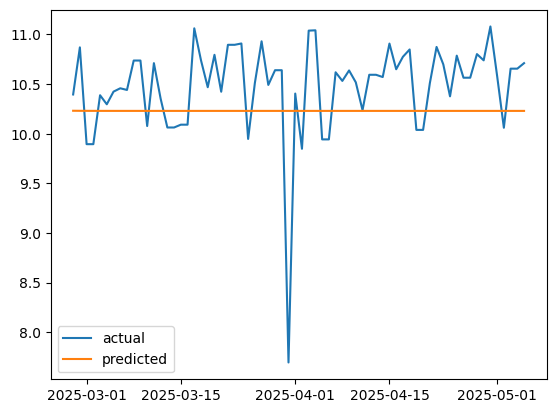

In [57]:
# plot the actual vs predicted results

plt.plot(val_data, label='actual')
plt.plot(predict, label='predicted')
plt.legend()
plt.show()

In [58]:
# Evaluate model persormance

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(val_data, predict)
mae = mean_absolute_error(val_data, predict)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Mean Squared Error: 0.28
Mean Absolute Error: 0.42


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


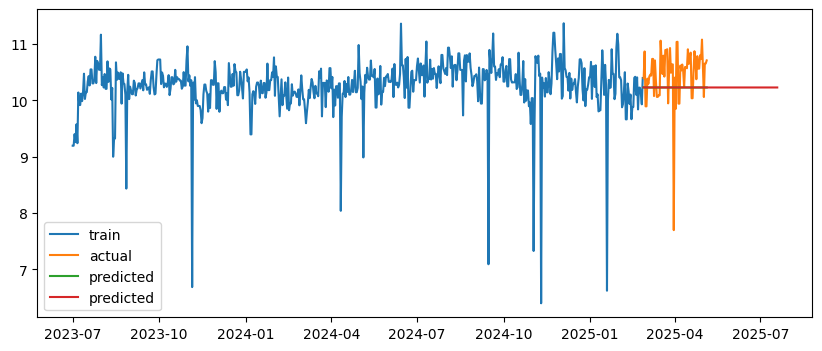

In [59]:
# Forecasting
future = model.predict(n_periods=len(test_data)+len(val_data))

plt.figure(figsize=(10,4))
plt.plot(train_data, label='train')
plt.plot(val_data, label='actual')
plt.plot(predict, label='predicted')
# plt.plot(test_data, label='actual')
plt.plot(future, label='predicted')
plt.legend()
plt.show()

It did **not capture any seasonality**, that's obvious because we assumed 'no stationarity', so **lets run the autoarima again** this time **enabling the model to learn some seasonality**

In [60]:
# Fit arima model to the series

model = auto_arima(train_data,seasonal=True, trace=False)
model.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  607
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -371.870
Date:                Wed, 06 Aug 2025   AIC                            751.740
Time:                        07:30:36   BIC                            769.368
Sample:                    07-01-2023   HQIC                           758.599
                         - 02-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6118      0.142      4.310      0.000       0.334       0.890
ma.L1         -1.4192      0.155     -9.175      0.000      -1.722      -1.116
ma.L2          0.4307      0.150      2.863      0.004       0.136       0.726
sigma2         0.1989      0.003     71.605      0.000       0.193       0.204
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             31486.85
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -4.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This means:

ARIMA (p=1, d=1, q=2)

So, the series was differenced once (d=1) to make it stationary.

**No seasonal parameters shown in this summary**, which suggests the best model didn't include SARIMA seasonal terms (i.e., no seasonal AR, seasonal MA, seasonal differencing, or seasonal period was selected, even though seasonal=True was used). Confirm this by checking if auto_arima returned seasonal_order=(0, 0, 0, 0).

Log Likelihood = -371.870: Higher is better (for comparing between models).

AIC = 751.740, BIC = 769.368: Lower is better. Use this to compare models.

HQIC = 758.599: Hybrid of AIC/BIC, lower is better.

→ **These are useful only when comparing multiple models. Alone, they don’t say whether the model is good or bad.**

In [61]:
# predict on test data
n_periods = len(val_data)
predict = model.predict(n_periods=n_periods)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


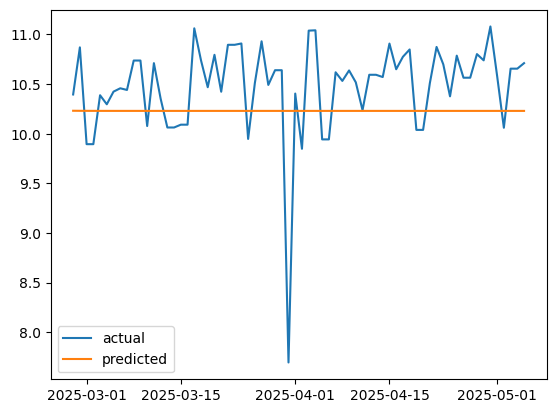

In [62]:
# plot the actual vs predicted results

plt.plot(val_data, label='actual')
plt.plot(predict, label='predicted')
plt.legend()
plt.show()

In [63]:
# before forecasting its better to update the model, letting it know that u dont have to predic from the end of training data from from the end of val_data

model.update(val_data)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [64]:

# now the forecasting will be done from the dates after the end of validation data
future = model.predict(n_periods=len(test_data))
future

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([10.51181026, 10.48809135, 10.4734627 , 10.46444046, 10.45887598,
       10.45544409, 10.45332746, 10.45202203, 10.45121691, 10.45072035,
       10.45041409, 10.45022521, 10.45010872, 10.45003687, 10.44999256,
       10.44996523, 10.44994837, 10.44993798, 10.44993156, 10.44992761,
       10.44992517, 10.44992367, 10.44992274, 10.44992217, 10.44992181,
       10.4499216 , 10.44992146, 10.44992138, 10.44992133, 10.4499213 ,
       10.44992128, 10.44992127, 10.44992126, 10.44992125, 10.44992125,
       10.44992125, 10.44992125, 10.44992125, 10.44992125, 10.44992125,
       10.44992125, 10.44992125, 10.44992125, 10.44992125, 10.44992125,
       10.44992125, 10.44992125, 10.44992125, 10.44992125, 10.44992125,
       10.44992125, 10.44992125, 10.44992125, 10.44992125, 10.44992125,
       10.44992125, 10.44992125, 10.44992125, 10.44992125, 10.44992125,
       10.44992125, 10.44992125, 10.44992125, 10.44992125, 10.44992125,
       10.44992125, 10.44992125, 10.44992125, 10.44992125, 10.44

In [65]:
# now we have to decompose the log-transformation back to the original terms, so as to understand the forecasted revenues
forecast_original = np.round(np.exp(future),2)
forecast_original

array([36746.94, 35885.6 , 35364.46, 35046.83, 34852.35, 34732.95,
       34659.51, 34614.3 , 34586.44, 34569.27, 34558.68, 34552.16,
       34548.13, 34545.65, 34544.12, 34543.17, 34542.59, 34542.23,
       34542.01, 34541.87, 34541.79, 34541.74, 34541.71, 34541.69,
       34541.67, 34541.67, 34541.66, 34541.66, 34541.66, 34541.66,
       34541.66, 34541.65, 34541.65, 34541.65, 34541.65, 34541.65,
       34541.65, 34541.65, 34541.65, 34541.65, 34541.65, 34541.65,
       34541.65, 34541.65, 34541.65, 34541.65, 34541.65, 34541.65,
       34541.65, 34541.65, 34541.65, 34541.65, 34541.65, 34541.65,
       34541.65, 34541.65, 34541.65, 34541.65, 34541.65, 34541.65,
       34541.65, 34541.65, 34541.65, 34541.65, 34541.65, 34541.65,
       34541.65, 34541.65, 34541.65, 34541.65, 34541.65, 34541.65,
       34541.65, 34541.65, 34541.65])

In [66]:
# this is done in order to match the dates, for the forecasted data

forecast_index = test_data.index  # use same index as test
predicted_series = pd.Series(future, index=forecast_index)

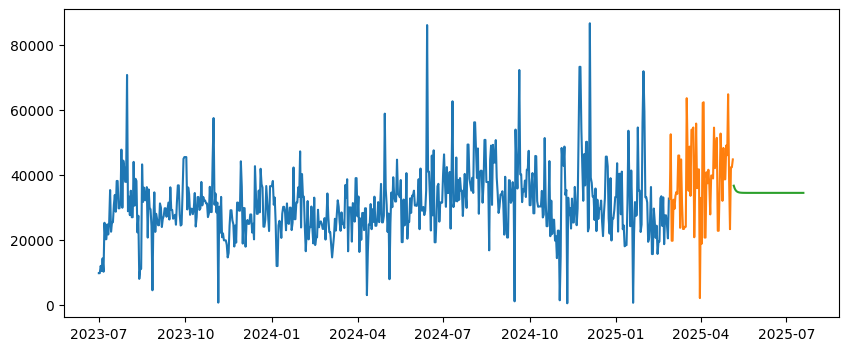

In [67]:
# plot the original and the forecasted
plt.figure(figsize=(10,4))
plt.plot(np.exp(train_data), label='train')
plt.plot(np.exp(val_data), label='actual')
plt.plot(np.exp(predicted_series), label='forecasted')

In [123]:
# now take a look at the original test data and the values forecasted for it
forecasted_table=pd.DataFrame({'Actual':np.exp(test_data['AMOUNT PAYABLE']), 'Forecasted':forecast_original, 'Diff':np.abs(np.exp(test_data['AMOUNT PAYABLE'])-forecast_original) })
# forecasted_table

KeyError: 'AMOUNT PAYABLE'

In [69]:
# make a percentage diff column
forecasted_table['% Diff'] = (forecasted_table['Diff']/forecasted_table['Actual'])*100
forecasted_table[:10]

,Actual,Forecasted,Diff,% Diff
DATE,,,,
2025-05-06 00:00:10,41550.0,36746.94,4803.06,11.559711
2025-05-07 00:00:10,40316.0,35885.60,4430.40,10.989185
2025-05-08 00:00:10,39762.5,35364.46,4398.04,11.060773
2025-05-09 00:00:10,64978.5,35046.83,29931.67,46.063960
2025-05-10 00:00:10,44153.5,34852.35,9301.15,21.065487
2025-05-11 00:00:10,44153.5,34732.95,9420.55,21.335908
2025-05-12 00:00:10,39693.0,34659.51,5033.49,12.681052
2025-05-13 00:00:10,56269.0,34614.30,21654.70,38.484245
2025-05-14 00:00:10,42518.0,34586.44,7931.56,18.654593


The forecast is **not very good**!, we have to **work on more models** and perhaps make the model **catch some seasonality** as well if there is.

# **Prophet to forecast revenue**

### **Prepare the dataset for Prophet**

In [70]:
from prophet import Prophet
import pandas as pd

In [71]:
# display the data
df.head()

,LOCATION,DATE,AMOUNT PAYABLE,SERVICE_CATEGORY
0,"Continua Kids, Rohtak",2023-07-01 00:00:10,13000,ABA
1,"Continua Kids, Rohtak",2023-07-01 00:00:10,18700,ABA
2,"Continua Kids, Rohtak",2023-07-01 00:00:10,0,ABA
3,"Continua Kids, Rohtak",2023-07-01 00:00:10,0,ABA
4,"Continua Kids, Rohtak",2023-07-01 00:00:10,0,ABA


In [72]:
# prophet expects a df with only two columns, so lets copy and make a new df[['Date','Revenue']]
df_prophet = df[['DATE','AMOUNT PAYABLE']].copy()

# rename the colu to ds, y
df_prophet.columns = ['ds','y']

# aggreagate the data Day-Wise
df_prophet = df_prophet.groupby('ds').sum().reset_index()

In [73]:
# ensure datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [74]:
# display metadata
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      678 non-null    datetime64[ns]
 1   y       678 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 10.7+ KB


In [75]:
# sort the data by
df_prophet = df_prophet.sort_values('ds')

### **Data Splitting**

In [76]:
# split the data into train, val, test
train_val_size = int(len(df_prophet)*0.99)
train_val_data, test_data = df_prophet[:train_val_size], df_prophet[train_val_size:]

# val data
train_size = int(len(train_val_data)*0.95)
train_data = train_val_data[:train_size]
val_data = train_val_data[train_size:]

In [77]:
train_data

,ds,y
0,2023-07-01 00:00:10,203982
1,2023-07-02 00:00:10,14400
2,2023-07-03 00:00:10,297414
3,2023-07-04 00:00:10,317410
4,2023-07-05 00:00:10,380250
...,...,...
632,2025-06-03 00:00:10,809577.0
633,2025-06-04 00:00:10,720025.0
634,2025-06-05 00:00:10,613086
635,2025-06-06 00:00:10,420731.0


In [78]:
val_data

,ds,y
637,2025-06-08 00:00:10,21600
638,2025-06-09 00:00:10,671785.5
639,2025-06-10 00:00:10,534614.0
640,2025-06-11 00:00:10,516975.0
641,2025-06-12 00:00:10,620021.5
642,2025-06-13 00:00:10,441154.0
643,2025-06-14 00:00:10,376400.0
644,2025-06-16 00:00:10,667116.5
645,2025-06-17 00:00:10,640579.5
646,2025-06-18 00:00:10,508937.5


In [79]:
test_data

,ds,y
671,2025-07-14 00:00:10,806752.0
672,2025-07-15 00:00:10,870454.0
673,2025-07-16 00:00:10,642809.5
674,2025-07-17 00:00:10,638548.0
675,2025-07-18 00:00:10,747876.5
676,2025-07-19 00:00:10,459646.5
677,2025-07-20 00:00:10,12000


### **Initialize and Fit prophet model**

In [80]:
# create a model instance
model = Prophet(seasonality_mode='additive' , yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# fit the model
model.fit(train_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmeg_5x1l/f11oz1wb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmeg_5x1l/wr10byr_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39395', 'data', 'file=/tmp/tmpmeg_5x1l/f11oz1wb.json', 'init=/tmp/tmpmeg_5x1l/wr10byr_.json', 'output', 'file=/tmp/tmpmeg_5x1l/prophet_modeldrfxyy_j/prophet_model-20250806073039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:30:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:30:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### **Predict and Model Evaluation**

In [81]:
# predict for val_data, to check for model performance
val_pred = model.make_future_dataframe(periods=len(val_data))

# predict the val_data
val_forecast = model.predict(val_pred)

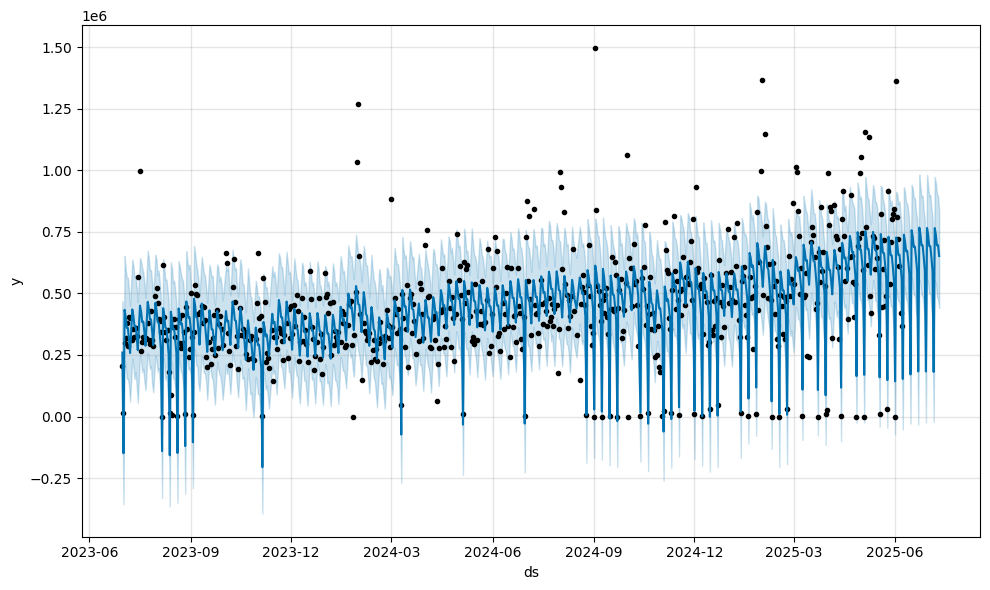

In [82]:
# plot the forecast and the val_data for model performance
model.plot(val_forecast);

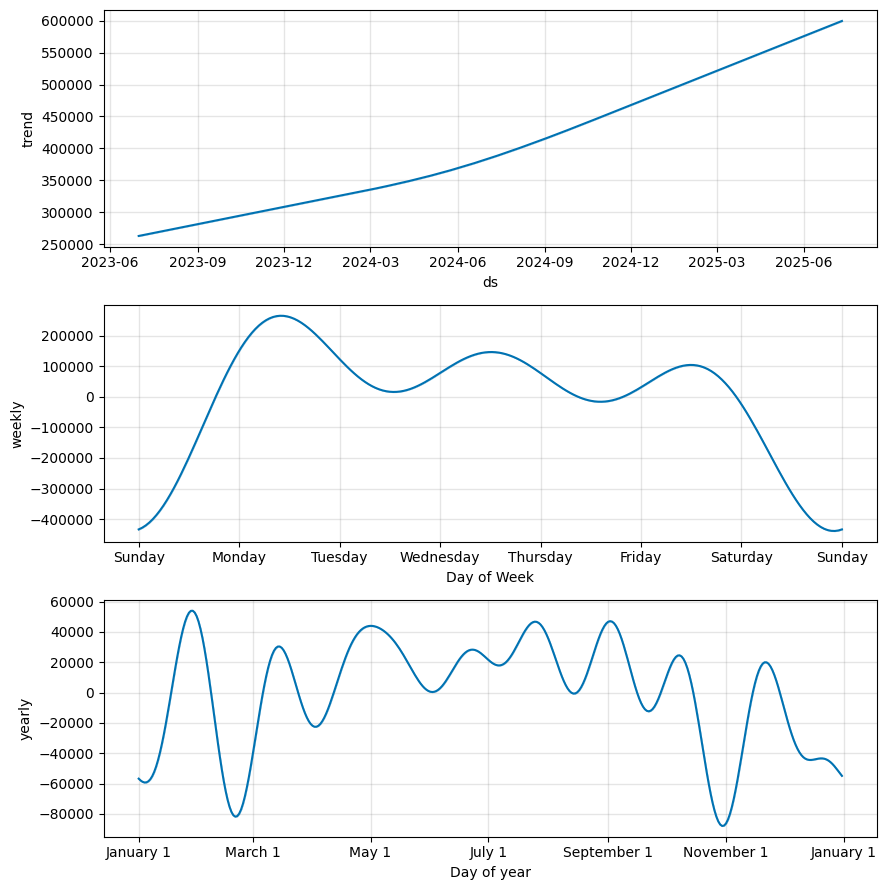

In [83]:
# plot the model components : trend, seasonality
model.plot_components(val_forecast);

In [84]:
# now evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

actual_val = val_data['y']
predicted_val = val_forecast['yhat'][-len(actual_val):]

mape = mean_absolute_percentage_error(actual_val, predicted_val)
mae = mean_absolute_error(actual_val, predicted_val)
mse = mean_squared_error(actual_val, predicted_val)

# display
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}")


Mean Absolute Error: 242403.97
Mean Squared Error: 141820619515.14
Mean Absolute Percentage Error: 6.46


In [85]:
df_prophet['y'].mean()

451359.26253687317

In [122]:
# print the val, and val forects vales side by side in a df
val_df = pd.DataFrame({'Date':val_data['ds'] ,'Actual': actual_val, 'Predicted': predicted_val})
# val_df

Overall , its able to capture the trend and seasonality, but the problem is that my model is **not able to caputre** the info that on **sundays the revenue should be 0**.

# **Prophet "Additive" including Sundays as extra regressor**

I want my model to learn that Sundays are ideally zero-revenue days, even if:

1.  Sometimes a small payment happens (noise)
2.  Often Sundays are missing altogether (no payment at all)

In [87]:
# since some data is still missing (0 payments made on most sundays, hense the dates are missing), so create a comple daily data range

full_df = pd.DataFrame({'ds': pd.date_range(start=df_prophet['ds'].min(), end=df_prophet['ds'].max())})
full_df

,ds
0,2023-07-01 00:00:10
1,2023-07-02 00:00:10
2,2023-07-03 00:00:10
3,2023-07-04 00:00:10
4,2023-07-05 00:00:10
...,...
746,2025-07-16 00:00:10
747,2025-07-17 00:00:10
748,2025-07-18 00:00:10
749,2025-07-19 00:00:10


In [88]:
# merge with the original data
df_full = full_df.merge(df_prophet, on='ds', how='left')
df_full['y'] = df_full['y'].fillna(0) # missing days get a value of 0

/tmp/ipython-input-167475834.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_full['y'] = df_full['y'].fillna(0) # missing days get a value of 0


In [121]:
# df_full[:30]

In [90]:
# Add a custom regressor to model Sundays as 0 revenue days

df_full['is_sunday'] = df_full['ds'].dt.dayofweek == 6  # 6 represents Sunday
df_full['is_sunday'] = df_full['is_sunday'].astype(int)

In [120]:
# df_full

In [92]:
# train test split again on df_full

train_size = int(len(df_full)*0.98)
train_data_2 = df_full[:train_size]
test_data_2 = df_full[train_size:]

In [93]:
# train the model with this custom regressor

model2 = Prophet(seasonality_mode='additive' , yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model2.add_regressor('is_sunday')

model2.fit(train_data_2[['ds','y','is_sunday']])

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmeg_5x1l/xcxqdqeh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmeg_5x1l/p5bgv4vf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43904', 'data', 'file=/tmp/tmpmeg_5x1l/xcxqdqeh.json', 'init=/tmp/tmpmeg_5x1l/p5bgv4vf.json', 'output', 'file=/tmp/tmpmeg_5x1l/prophet_modelpmlrngzd/prophet_model-20250806073041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:30:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:30:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [94]:
# make future predictions df

future = model2.make_future_dataframe(periods=len(test_data_2), include_history=False)
future['is_sunday'] = future['ds'].dt.dayofweek == 6
future['is_sunday'] = future['is_sunday'].astype('int')

forecast_2  = model2.predict(future)

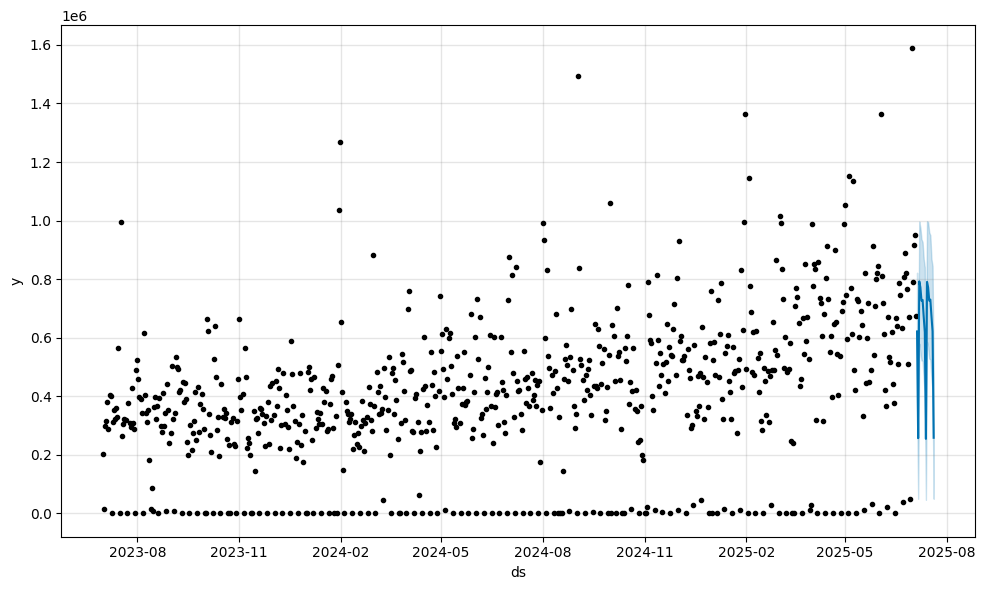

In [95]:
# plot the model future

model2.plot(forecast_2);

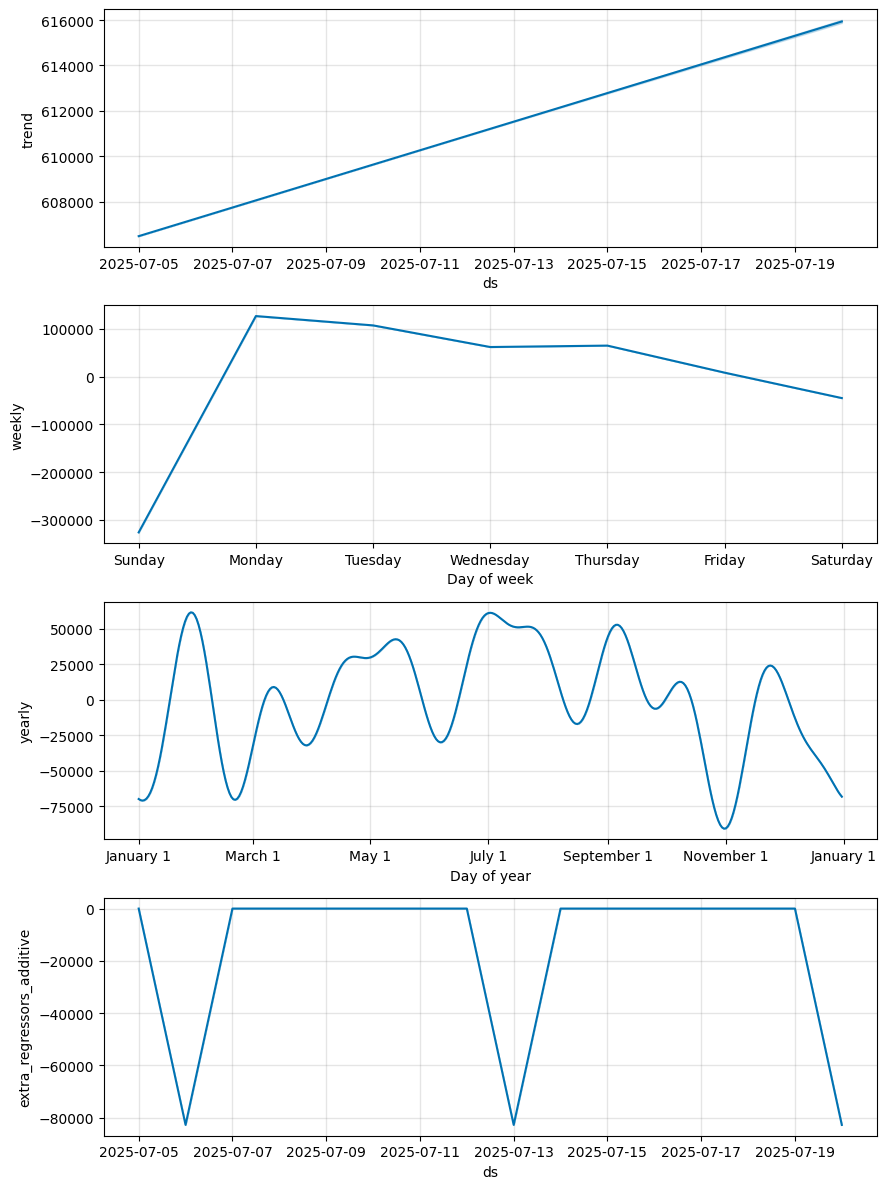

In [96]:
# plot the model's components
model2.plot_components(forecast_2);

In [97]:
# model evaluation

actual_val = test_data_2['y']
predicted_val = forecast_2['yhat'][-len(actual_val):]

mape = mean_absolute_percentage_error(actual_val, predicted_val)
mae = mean_absolute_error(actual_val, predicted_val)

# display
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}")

Mean Absolute Error: 118545.59
Mean Absolute Percentage Error: 72364346314029744128.00


In [119]:
forecated_0 = pd.DataFrame({'Date':test_data_2['ds'] , 'actual' :test_data_2['y'] , 'predicted' : forecast_2['yhat']})
# forecated_0

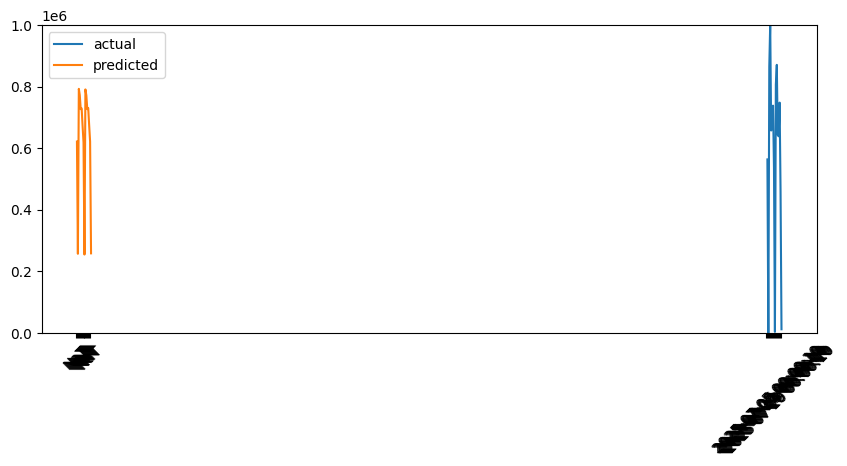

In [99]:
# plot the forecasted , actual vs predicted
plt.figure(figsize=(10,4))
plt.plot(forecated_0['actual'], label='actual')
plt.plot(forecated_0['predicted'], label='predicted')

# dates on x-asix
plt.xticks(forecated_0.index-1, forecated_0['Date'], rotation=45)

# proper revenue on y-axis
plt.ylim(0, 1000000)
plt.legend()

plt.show()

# **Prophet "Multiplicative" including Sundays as extra regressor**

In [100]:
# initialize a model instance keeping model as Multiplicative

model3 = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

In [101]:
# add is_sunday as a regressor
model3.add_regressor('is_sunday')

# fit the model
model3.fit(train_data_2[['ds','y','is_sunday']])

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmeg_5x1l/_ds2rdkq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmeg_5x1l/0utat8uh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15706', 'data', 'file=/tmp/tmpmeg_5x1l/_ds2rdkq.json', 'init=/tmp/tmpmeg_5x1l/0utat8uh.json', 'output', 'file=/tmp/tmpmeg_5x1l/prophet_model0mtint0v/prophet_model-20250806073043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:30:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:30:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [102]:
# make future dataframe
future = model3.make_future_dataframe(periods=len(test_data_2), include_history=False)
future['is_sunday'] = future['ds'].dt.dayofweek == 6
future['is_sunday'] = future['is_sunday'].astype('int')

forecast_3 = model3.predict(future)

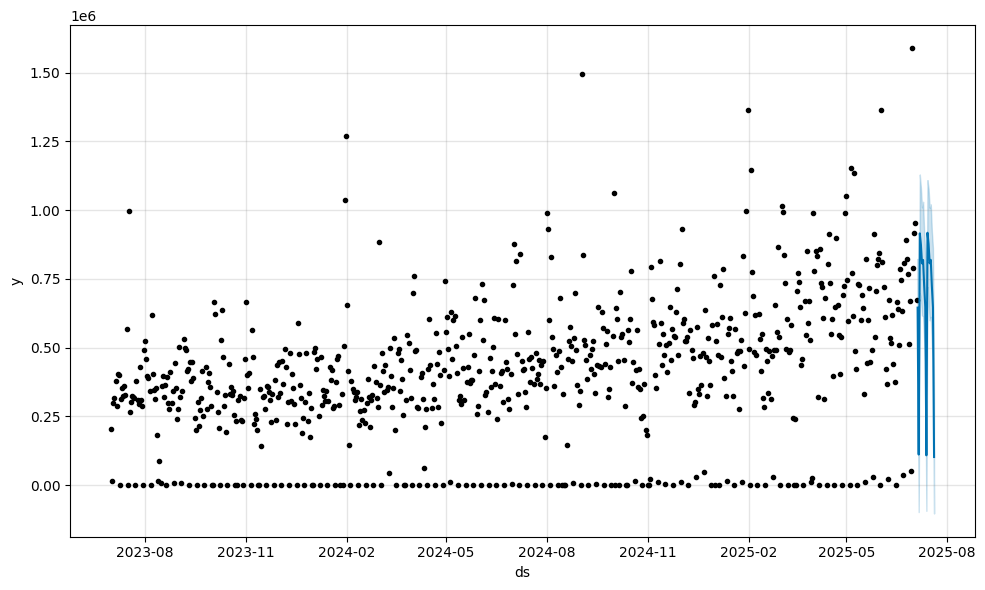

In [103]:
# plot the model forecast
model3.plot(forecast_3);

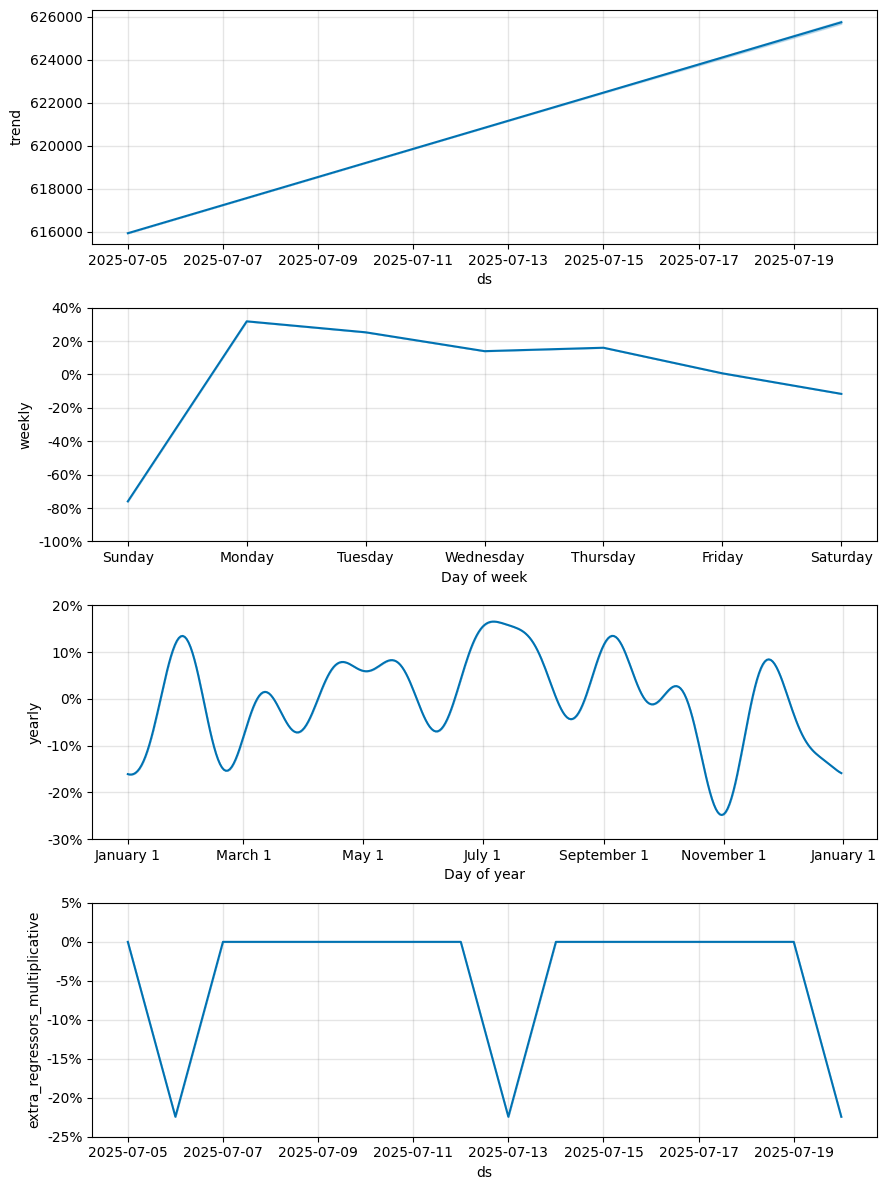

In [104]:
# plot the models components
model3.plot_components(forecast_3);

In [105]:
# model evaluation

actual_val = test_data_2['y']
predicted_val = forecast_3['yhat'][-len(actual_val):]

mape = mean_absolute_percentage_error(actual_val, predicted_val)
mae = mean_absolute_error(actual_val, predicted_val)

# display
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}")


Mean Absolute Error: 102561.13
Mean Absolute Percentage Error: 31347865619947614208.00


In [106]:
test_data_2.reset_index(drop=True, inplace=True)

In [118]:
forecated = pd.DataFrame({'Date':test_data_2['ds'] , 'actual' :test_data_2['y'] , 'predicted' : forecast_3['yhat']})
# forecated

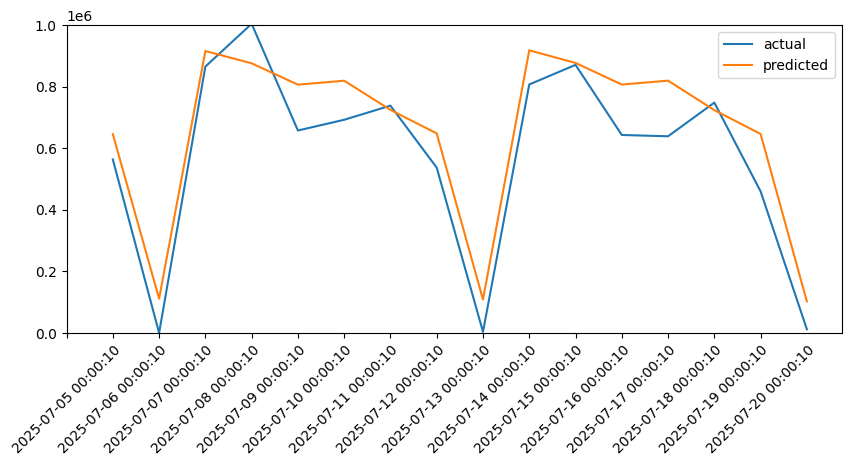

In [108]:
# plot the forecasted , actual vs predicted
plt.figure(figsize=(10,4))
plt.plot(forecated['actual'], label='actual')
plt.plot(forecated['predicted'], label='predicted')

# dates on x-asix
plt.xticks(forecated.index-1, forecated['Date'], rotation=45)

# proper revenue on y-axis
plt.ylim(0, 1000000)
plt.legend()

plt.show()

 **It's doing a pretty descent job!!**

# **Final Prophet Forecast Code (with July Projection)**

**Case**: Given data till 10th of a month, predict the current month's monthly revenue of the organization.

In [109]:
# Step 1: install libs
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [110]:
# data at hand
df.head()

,LOCATION,DATE,AMOUNT PAYABLE,SERVICE_CATEGORY
0,"Continua Kids, Rohtak",2023-07-01 00:00:10,13000,ABA
1,"Continua Kids, Rohtak",2023-07-01 00:00:10,18700,ABA
2,"Continua Kids, Rohtak",2023-07-01 00:00:10,0,ABA
3,"Continua Kids, Rohtak",2023-07-01 00:00:10,0,ABA
4,"Continua Kids, Rohtak",2023-07-01 00:00:10,0,ABA


In [111]:
# Step : 2Data for prophet

#use df_full as the data preprocessed for prophet df_full[['ds','y','is_sunday']]
df_full.tail()

daily_revenue = df_full.copy()
daily_revenue

,ds,y,is_sunday
0,2023-07-01 00:00:10,203982.0,0
1,2023-07-02 00:00:10,14400.0,1
2,2023-07-03 00:00:10,297414.0,0
3,2023-07-04 00:00:10,317410.0,0
4,2023-07-05 00:00:10,380250.0,0
...,...,...,...
746,2025-07-16 00:00:10,642809.5,0
747,2025-07-17 00:00:10,638548.0,0
748,2025-07-18 00:00:10,747876.5,0
749,2025-07-19 00:00:10,459646.5,0


/tmp/ipython-input-3541358618.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['is_sunday'] = train_data['ds'].dt.dayofweek.apply(lambda x: 1 if x == 6 else 0)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmeg_5x1l/5c2rkf5s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmeg_5x1l/zm2b3w1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28147', 'data', 'file=/tmp/tmpmeg_5x1l/5c2rkf5s.json', 'init=/tmp/tmpmeg_5x1l/zm2b3w1k.json', 'output', 'file=/tmp/tmpmeg_5x1l/prophet_modeler008ox6/prophet_model-20250806073047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:30:47 - cmdstanpy

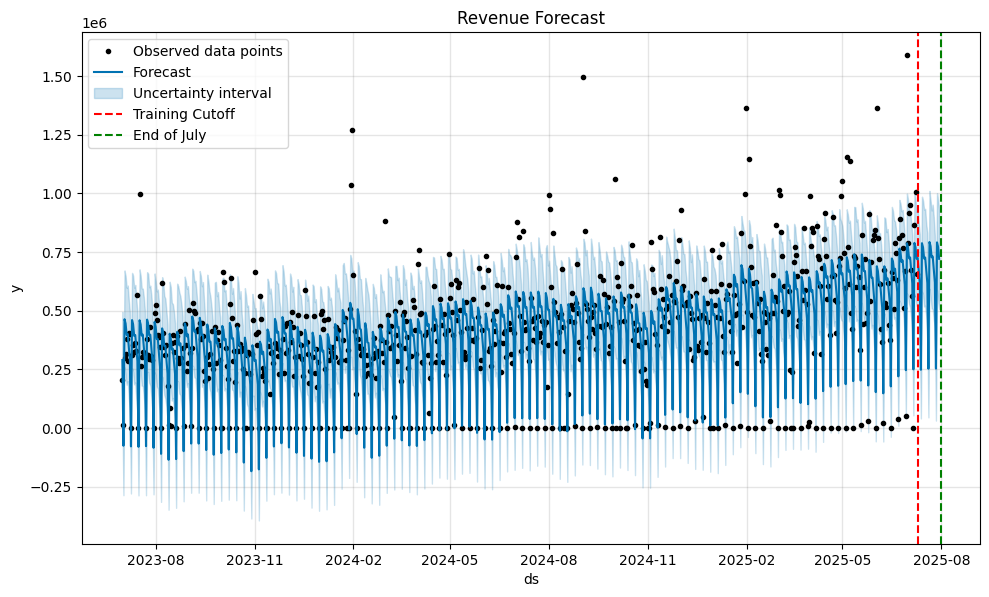

Forecasted Revenue for 11–31 July 2025: ₹12,939,697.97


In [112]:
# Ensure proper datetime format
daily_revenue['ds'] = pd.to_datetime(daily_revenue['ds'])

# Step 3: Filter data till 10th July 2025
cutoff_date = pd.to_datetime("2025-07-10")
train_data = daily_revenue[daily_revenue['ds'] <= cutoff_date]

# Step 4: Add regressor to treat Sundays (optional but useful)
train_data['is_sunday'] = train_data['ds'].dt.dayofweek.apply(lambda x: 1 if x == 6 else 0)

# Step 5: Initialize and fit Prophet
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
model.add_regressor('is_sunday')

model.fit(train_data)

# Step 6: Create future dataframe
future = model.make_future_dataframe(periods=21)  # remaining days of July
future['is_sunday'] = future['ds'].dt.dayofweek.apply(lambda x: 1 if x == 6 else 0)

# Step 7: Forecast
forecast = model.predict(future)

# Optional: Plot full forecast
model.plot(forecast)
plt.axvline(pd.to_datetime('2025-07-10'), color='r', linestyle='--', label='Training Cutoff')
plt.axvline(pd.to_datetime('2025-08-01'), color='g', linestyle='--', label='End of July')
plt.title("Revenue Forecast")
plt.legend()
plt.show()

# Step 8: Filter July 2025 predictions only
july_preds = forecast[(forecast['ds'] >= '2025-07-11') & (forecast['ds'] <= '2025-07-31')]

# Step 9: Summarize forecasted revenue for July
july_total = july_preds['yhat'].sum()
print(f"Forecasted Revenue for 11–31 July 2025: ₹{july_total:,.2f}")


In [113]:
# Total Revenue for the month of July 2025
from babel.numbers import format_currency  # to display currency in indian decimal system

july_month_total = july_total + train_data[-9:]['y'].sum()
july_month_total_revenue = format_currency(july_month_total, 'INR', locale='en_IN')
print(f"Total Revenue for the month of July 2025: {july_month_total_revenue}")

Total Revenue for the month of July 2025: ₹1,93,58,713.47


**At the end of the July month, I extracted revenue 'Non_GST' data using SQL (my sql workbench) and computed the total monthly revenue, aggregate of all the 31 clinics of my organization. It was around 2 Cr and some thousands.**



> ***Final words:***

    I think the model did a great job at being able to predict the monthly revenue with some degree of accuracy.

    However, more work can be done, smoothing can be applied, both Holts (for trend alone) and Holts winter smoothing (for both trend and seasonality).

    Multi-series analysis can be experimented with using Prophet.


# **End of the TSA Project.**